In [85]:
import gurobipy as gp
import numpy as np
import pandas as pd
from math import *
from copy import deepcopy
import seaborn as sns
from matplotlib import pyplot as plt

### Ler capacidades

In [86]:
df_oferta = pd.read_excel('../dados/ibge_prod.xlsx', index_col=0)
df_oferta.head()

,2017,2018,2019,2020,2021,Média
"Brasil, Unidade da Federação e Município",,,,,,
Goiás,11372539,11476946,11080442,12849800,13654117,7756720.664
"Rio Verde, GO, Brazil",1102500,1170000,1081200,1404000,1476000,947522.400
"Jataí, GO, Brazil",1060200,1026000,1061900,1060200,1078800,803639.200
"Cristalina, GO, Brazil",811200,860000,694100,936000,993750,652847.600
"Montividiu, GO, Brazil",455880,454860,421200,496800,468600,349195.680


In [87]:
oferta_total = df_oferta['Média'].sum() - df_oferta['Média']['Goiás']
N = [i for i in (set(df_oferta.index) - set(['Goiás']))]
qnt_orig = len(N)

In [88]:
oferta_total

7756720.663999998

In [89]:
supply = {}
for i in N:
    supply[i.lower()] = df_oferta['Média'][i]
supply

{'padre bernardo, go, brazil': 141554.56,
 'niquelândia, go, brazil': 124868.0,
 'santa helena de goiás, go, brazil': 131920.8,
 'cristalina, go, brazil': 652847.6,
 'gameleira de goiás, go, brazil': 69926.08,
 'bom jesus de goiás, go, brazil': 152946.96,
 'vicentinópolis, go, brazil': 55945.12,
 'itaberaí, go, brazil': 48419.6,
 'morrinhos, go, brazil': 77611.2,
 'ipameri, go, brazil': 253140.80000000002,
 'montes claros de goiás, go, brazil': 88170.33600000001,
 'doverlândia, go, brazil': 46843.36,
 'paraúna, go, brazil': 300804.96,
 'palmeiras de goiás, go, brazil': 86804.16,
 'serranópolis, go, brazil': 80596.48,
 'acreúna, go, brazil': 124916.64,
 "são joão d'aliança, go, brazil": 94696.0,
 'turvelândia, go, brazil': 64432.8,
 'caldas novas, go, brazil': 81122.4,
 'goiatuba, go, brazil': 195412.72,
 'joviânia, go, brazil': 54455.520000000004,
 'uruaçu, go, brazil': 59553.6,
 'edealina, go, brazil': 60315.728,
 'cabeceiras, go, brazil': 75072.8,
 'água fria de goiás, go, brazil': 1

In [90]:
df_cap_porto = pd.read_excel('../dados/ibge_cap_porto.xlsx')
df_cap_porto.head()

,"SANTOS, SP, Brazil","VITÓRIA, ES, Brazil","SÃO LUIZ, MA, Brazil","ILHÉUS, BA, Brazil",Total
0,5041870.6,620537.92,1628912.04,465403.44,7756724.0


In [91]:
demanda_total = df_cap_porto['Total'][0]
M = [i for i in (set(df_cap_porto.columns) - set(['Total']))]
qnt_port = len(M)

In [92]:
demanda_total

7756724.000000001

In [93]:
cap_port = {}
for i in M:
    cap_port[i.lower()] = df_cap_porto[i][0]
print(sum([cap_port[i] for i in cap_port]))

7756724.000000001


In [94]:
df_cap_trans = pd.read_excel('../dados/ibge_cap_transbordo.xlsx')
df_cap_trans.head()

,"PORTO NACIONAL, TO, Brazil","FIGUEIRÓPOLIS, TO, Brazil","PORANGATU, GO, Brazil","ANÁPOLIS, GO, Brazil","IPAMERI,GO, Brazil","RIO VERDE, GO, Brazil","SÃO SIMÃO, GO, Brazil"
0,240458.444,2745880.296,729132.056,294755.512,178404.652,2831204.26,736888.78


In [95]:
K = [i for i in (set(df_cap_trans.columns))]
qnt_trans = len(K)

In [96]:
cap_trans = {}
for i in K:
    cap_trans[i.lower()] = df_cap_trans[i][0]
cap_trans

{'ipameri,go, brazil': 178404.65200000003,
 'figueirópolis, to, brazil': 2745880.296,
 'porangatu, go, brazil': 729132.056,
 'anápolis, go, brazil': 294755.51200000005,
 'rio verde, go, brazil': 2831204.26,
 'porto nacional, to, brazil': 240458.444,
 'são simão, go, brazil': 736888.7800000001}

In [97]:
O = [qnt_orig + qnt_trans + qnt_port]
demand = { O[0]: demanda_total }

### Ler matriz de frete

In [98]:
df_cost_origem_trans = pd.read_excel('../dados/ibge_cost_origem_transbordo.xlsx', index_col=0)
df_cost_origem_trans.head()

,"CANAÃ DOS CARAJÁS, PA, Brazil","PORTO NACIONAL, TO, Brazil","FIGUEIRÓPOLIS, TO, Brazil","PORANGATU, GO, Brazil","ANÁPOLIS, GO, Brazil","IPAMERI,GO, Brazil","RIO VERDE, GO, Brazil","SÃO SIMÃO, GO, Brazil","SÃO JOSÉ DA LAPA, MG, Brazil","LONDRINA, PR, Brazil","MARINGÁ, PR, Brazil"
Origem,,,,,,,,,,,
"Rio Verde, GO, Brazil",262.335670,167.546841,136.900218,110.254099,59.230208,70.679276,15.269992,41.576239,149.239214,131.288603,131.898136
"Jataí, GO, Brazil",254.072456,181.260231,150.613609,123.717505,72.693614,84.211998,29.054190,44.284930,162.771936,131.830609,132.440292
"Cristalina, GO, Brazil",250.655251,146.483120,116.543968,94.047270,49.687555,40.688249,89.256266,97.003262,103.129754,168.992788,166.818352
"Montividiu, GO, Brazil",261.273868,166.485038,135.838416,108.694861,65.845043,77.845359,22.668769,49.661021,156.405297,139.373384,139.982918
"Paraúna, GO, Brazil",243.427454,148.638475,117.991853,90.848298,47.998480,62.256710,34.204593,55.712980,157.585757,144.799412,152.264076


In [99]:
df_cost_origem_porto = pd.read_excel('../dados/ibge_cost_origem_porto.xlsx', index_col=0)
df_cost_origem_porto.head()

,"SANTOS, SP, Brazil","VITÓRIA, ES, Brazil","SÃO LUIZ, MA, Brazil","ILHÉUS, BA, Brazil","SALVADOR, BA, Brazil","RIO GRANDE, RS, Brazil","SÃO FRANCISCO DO SUL, SC, Brazil","BARCARENA, PA, Brazil","SANTAREM, PA, Brazil","ITACOATIARA, AM, Brazil","PARANAGUA, PR, Brazil","IMBITUBA, SC, Brazil"
Origem,,,,,,,,,,,,
"Rio Verde, GO, Brazil",164.863193,221.511668,352.994607,275.310584,294.872458,332.541761,214.890722,335.725379,383.039745,509.475583,203.497852,244.535318
"Jataí, GO, Brazil",173.330927,235.044539,366.707997,288.774139,308.336013,333.083768,215.432728,349.438770,369.915764,496.351602,204.039859,245.077324
"Cristalina, GO, Brazil",157.418802,181.280206,331.517971,206.704128,245.011288,344.596785,226.945745,323.571077,387.849680,574.595668,212.734025,256.590341
"Montividiu, GO, Brazil",172.029127,228.677751,351.932804,281.925419,301.487293,340.626394,222.975503,334.663726,375.880369,509.438763,211.582634,252.620099
"Paraúna, GO, Brazil",173.209586,229.858211,334.086390,264.078856,283.640879,360.387569,242.736679,316.817163,378.903740,526.603048,228.524809,272.381275


In [100]:
df_cost_trans_port = pd.read_excel('../dados/ibge_cost_transbordo_porto.xlsx', index_col=0)
df_cost_trans_port.head()

,"SANTOS, SP, Brazil","VITÓRIA, ES, Brazil","SÃO LUIZ, MA, Brazil","ILHÉUS, BA, Brazil","SALVADOR, BA, Brazil","RIO GRANDE, RS, Brazil","SÃO FRANCISCO DO SUL, SC, Brazil","BARCARENA, PA, Brazil","SANTAREM, PA, Brazil","ITACOATIARA, AM, Brazil","PARANAGUA, PR, Brazil","IMBITUBA, SC, Brazil"
"CANAÃ DOS CARAJÁS, PA, Brazil",1000000.00,1000000.00,79.28,1000000.00,1000000.0,1000000.0,1000000.0,1000000,1000000,1000000,1000000,1000000
"PORTO NACIONAL, TO, Brazil",153.32,170.01,95.63,125.06,1000000.0,1000000.0,1000000.0,1000000,1000000,1000000,1000000,1000000
"FIGUEIRÓPOLIS, TO, Brazil",139.27,155.64,109.68,111.01,1000000.0,1000000.0,1000000.0,1000000,1000000,1000000,1000000,1000000
"PORANGATU, GO, Brazil",130.96,147.33,117.99,119.32,1000000.0,1000000.0,1000000.0,1000000,1000000,1000000,1000000,1000000
"ANÁPOLIS, GO, Brazil",111.78,123.23,142.41,143.42,1000000.0,1000000.0,1000000.0,1000000,1000000,1000000,1000000,1000000


In [101]:
cost = {}
for n in N:
    for m in M:
        assert((n, m) not in cost)
        cost[n, m] = df_cost_origem_porto[m][n]
    for k in K:
        assert((n, k) not in cost)
        cost[n, k] = df_cost_origem_trans[k][n]
for k in K:
    for m in set(df_cost_trans_port.columns):
        assert((k, m) not in cost)
        cost[k, m] = df_cost_trans_port[m][k]
for j in M:
    cost[j, O[0]] = 0

### Ler matriz de CO2

In [102]:
df_emission_origem_trans = pd.read_excel('../dados/ibge_emission_origem_transbordo.xlsx', index_col=0)
df_emission_origem_trans.head()

,"CANAÃ DOS CARAJÁS, PA, Brazil","PORTO NACIONAL, TO, Brazil","FIGUEIRÓPOLIS, TO, Brazil","PORANGATU, GO, Brazil","ANÁPOLIS, GO, Brazil","IPAMERI,GO, Brazil","RIO VERDE, GO, Brazil","SÃO SIMÃO, GO, Brazil","SÃO JOSÉ DA LAPA, MG, Brazil","LONDRINA, PR, Brazil","MARINGÁ, PR, Brazil"
Origem,,,,,,,,,,,
"Rio Verde, GO, Brazil",87461895.09,53906401.95,43057417.65,33624621.84,15562031.31,19615031.16,0.00,9312480.21,47425454.40,41070891.00,41286667.53
"Jataí, GO, Brazil",84536695.68,58760978.10,47911993.80,38390702.70,20328112.17,24405650.07,4879641.90,10271363.88,52216073.31,41262762.72,41478592.02
"Cristalina, GO, Brazil",83326996.20,46449789.87,35851251.99,27887361.90,12183906.99,8998129.32,26191334.10,28933791.00,31102585.23,54418270.95,53648514.96
"Montividiu, GO, Brazil",87086014.38,53530521.24,42681536.94,33072647.64,17903700.06,22151843.37,2619186.18,12174513.93,49962266.61,43932924.72,44148701.25
"Paraúna, GO, Brazil",80768337.21,47212791.30,36363807.00,26754917.70,11585970.12,16633420.62,6702898.17,14316923.16,50380152.24,45853752.72,48496263.24


In [103]:
df_emission_origem_porto = pd.read_excel('../dados/ibge_emission_origem_porto.xlsx', index_col=0)
df_emission_origem_porto.head()

,"SANTOS, SP, Brazil","VITÓRIA, ES, Brazil","SÃO LUIZ, MA, Brazil","ILHÉUS, BA, Brazil","SALVADOR, BA, Brazil","RIO GRANDE, RS, Brazil","SÃO FRANCISCO DO SUL, SC, Brazil","BARCARENA, PA, Brazil","SANTAREM, PA, Brazil","ITACOATIARA, AM, Brazil","PARANAGUA, PR, Brazil","IMBITUBA, SC, Brazil"
Origem,,,,,,,,,,,,
"Rio Verde, GO, Brazil",52956383.64,73010091.81,1.195554e+08,92055048.66,9.898000e+07,1.123150e+08,70666259.49,1.134420e+08,1.301915e+08,1.749501e+08,66633153.93,81160523.85
"Jataí, GO, Brazil",55953983.49,77800763.49,1.244100e+08,96821182.29,1.037461e+08,1.125069e+08,70858131.21,1.182966e+08,1.255455e+08,1.703041e+08,66825025.65,81352395.57
"Cristalina, GO, Brazil",50321049.84,58768049.28,1.119526e+08,67768183.86,8.132902e+07,1.165825e+08,74933769.39,1.091394e+08,1.318942e+08,1.980027e+08,69902783.13,85428033.75
"Montividiu, GO, Brazil",55493143.08,75546904.02,1.191795e+08,94396717.41,1.013217e+08,1.151770e+08,73528293.21,1.130662e+08,1.276570e+08,1.749370e+08,69495187.65,84022557.57
"Paraúna, GO, Brazil",55911028.71,75964789.65,1.128618e+08,88078987.47,9.500399e+07,1.221725e+08,80523801.03,1.067485e+08,1.287273e+08,1.810132e+08,75492762.00,91018065.39


In [104]:
df_emission_trans_port = pd.read_excel('../dados/ibge_emission_transbordo_porto.xlsx', index_col=0)
df_emission_trans_port.head()

,"SANTOS, SP, Brazil","VITÓRIA, ES, Brazil","SÃO LUIZ, MA, Brazil","ILHÉUS, BA, Brazil","SALVADOR, BA, Brazil","RIO GRANDE, RS, Brazil","SÃO FRANCISCO DO SUL, SC, Brazil","BARCARENA, PA, Brazil","SANTAREM, PA, Brazil","ITACOATIARA, AM, Brazil","PARANAGUA, PR, Brazil","IMBITUBA, SC, Brazil"
"CANAÃ DOS CARAJÁS, PA, Brazil",1.000000e+08,1.000000e+08,17082.52,1.000000e+08,100000000.0,100000000.0,100000000.0,100000000,100000000,100000000,100000000,100000000
"PORTO NACIONAL, TO, Brazil",4.153317e+04,4.704492e+04,22484.95,3.220120e+04,100000000.0,100000000.0,100000000.0,100000000,100000000,100000000,100000000,100000000
"FIGUEIRÓPOLIS, TO, Brazil",3.689432e+04,4.230142e+04,27123.80,2.756235e+04,100000000.0,100000000.0,100000000.0,100000000,100000000,100000000,100000000,100000000
"PORANGATU, GO, Brazil",3.415072e+04,3.955782e+04,29867.40,3.030595e+04,100000000.0,100000000.0,100000000.0,100000000,100000000,100000000,100000000,100000000
"ANÁPOLIS, GO, Brazil",2.781517e+04,3.159777e+04,37932.10,3.826600e+04,100000000.0,100000000.0,100000000.0,100000000,100000000,100000000,100000000,100000000


In [105]:
emission = {}
for n in N:
    for m in M:
        assert((n, m) not in emission)
        emission[n, m] = df_emission_origem_porto[m][n]
    for k in K:
        assert((n, k) not in emission)
        emission[n, k] = df_emission_origem_trans[k][n]
for k in K:
    for m in set(df_emission_trans_port.columns):
        assert((k, m) not in emission)
        emission[k, m] = df_emission_trans_port[m][k]
for i in M:
    emission[i, O[0]] = 0

### Construcao do modelo

In [106]:
m = gp.Model("lalalala")

In [107]:
X = {}
for i in N:
    for j in M:
        X[i, j] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="supply_{}_port_{}".format(i, j))

for i in N:
    for k in K:
        X[i, k] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="supply_{}_tranship_{}".format(i, k))
                
for j in M:
    for k in K:
        X[k, j] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="tranship_{}_port_{}".format(k, j))

for j in M:
    for o in O:
        X[j, o] = m.addVar(vtype=gp.GRB.CONTINUOUS, lb=0, name="X_{}_{}".format(j, o))

In [108]:
m.setObjectiveN(
    gp.quicksum((X[i, j] * cost[i, j]) for i in N for j in M) + \
    gp.quicksum((X[i, k] * cost[i, k]) for i in N for k in K) + \
    gp.quicksum((X[k, j] * cost[k, j]) for j in M for k in K),
    0,
    priority=2,
    name="Funcao Frete"
)

In [109]:
m.setObjectiveN(
    gp.quicksum((X[i, j] * emission[i, j]) for i in N for j in M) + \
    gp.quicksum((X[i, k] * emission[i, k]) for i in N for k in K) + \
    gp.quicksum((X[k, j] * emission[k, j]) for j in M for k in K),
    1,
    priority=1,
    name="Funcao Emissao CO2"
)

In [110]:
if oferta_total <= demanda_total:
    for i in N:
        m.addConstr(
            (gp.quicksum(X[i, j] for j in M) + gp.quicksum(X[i, k] for k in K)) == supply[i.lower()]
        )
else:
    for i in N:
        m.addConstr(
            (gp.quicksum(X[i, j] for j in M) + gp.quicksum(X[i, k] for k in K)) <= supply[i.lower()]
        )

In [111]:
if oferta_total < demanda_total:
    for o in O:
        m.addConstr(
            gp.quicksum(X[j, o] for j in M) <= demand[o]
        )
else:
    for o in O:
        m.addConstr(
            gp.quicksum(X[j, o] for j in M) == demand[o]
        )

In [112]:
for j in M:
    m.addConstr(
        (gp.quicksum(X[i, j] for i in N) + gp.quicksum(X[k, j] for k in K)) <= cap_port[j.lower()]
    )

for k in K:
    m.addConstr(
        gp.quicksum(X[i, k] for i in N) <= cap_trans[k.lower()]
    )

for k in K:
    m.addConstr(
        gp.quicksum(X[i, k] for i in N) == gp.quicksum(X[k, j] for j in M)
    )

for j in M:
    m.addConstr(
        gp.quicksum(X[j, o] for o in O) == (gp.quicksum(X[i, j] for i in N) + gp.quicksum(X[k, j] for k in K))
    )

In [113]:
rest = m.addConstrs(
    gp.quicksum(X[i, j] for i in N) >= 0 for j in M
)

rest = m.addConstrs(
    gp.quicksum(X[i, k] for i in N) >= 0 for k in K
)

rest = m.addConstrs(
    gp.quicksum(X[k, j] for k in K) >= 0 for j in M
)

In [114]:
m.Params.Method = -1

In [115]:
vals = []

In [116]:
m.setParam('TimeLimit', 60*9)
m.setParam(gp.GRB.Param.Threads, 1)
m.Params.LogToConsole = 0

Set parameter TimeLimit to value 540
Set parameter Threads to value 1


In [117]:
m.update()
m.optimize()

In [118]:
m.write('out.sol')

In [119]:
X[('Paraúna, GO, Brazil', 'VITÓRIA, ES, Brazil')].x

0.0

### Resultados origem pra porto

In [120]:
def save_op(cnt, obj1, obj2) -> None:
    df_ans = pd.DataFrame()
    writer = pd.ExcelWriter('../results_exact/' + str(int(cnt)) + '_origem_porto.xlsx', engine='openpyxl')
    df_ans['Origem'] = N

    for j in M:
        aux = []
        for i in N:
            aux.append(X[(i, j)].x)
        df_ans[j] = aux
    df_ans.to_excel(writer,'Quantidade Transportada', index=False)

    df_ans = pd.DataFrame()
    for j in M:
        aux = []
        for i in N:
            aux.append(X[(i, j)].x * cost[i, j])
        df_ans[j] = aux
    df_ans.to_excel(writer,'Frete', index=False)

    df_ans = pd.DataFrame()
    for j in M:
        aux = []
        for i in N:
            aux.append(X[(i, j)].x * emission[i, j])
        df_ans[j] = aux
    df_ans.to_excel(writer,'Emissão CO2', index=False)

    df_ans = pd.DataFrame()
    df_ans['Frete total'] = [obj1]
    df_ans['Emissão total'] = [obj2]
    df_ans.to_excel(writer, 'Função Objetivo', index=False)

    writer.close()

### Resultados transbordo para porto

In [121]:
def save_tp(cnt, obj1, obj2) -> None:
    df_ans = pd.DataFrame()
    writer = pd.ExcelWriter('../results_exact/' + str(int(cnt)) + '_transbordo_porto.xlsx', engine='openpyxl')
    df_ans['Transbordo'] = K

    for j in M:
        aux = []
        for k in K:
            aux.append(X[(k, j)].x)
        df_ans[j] = aux
    df_ans.to_excel(writer,'Quantidade Transportada', index=False)

    df_ans = pd.DataFrame()
    for j in M:
        aux = []
        for k in K:
            aux.append(X[(k, j)].x * cost[k, j])
        df_ans[j] = aux
    df_ans.to_excel(writer,'Frete', index=False)

    df_ans = pd.DataFrame()
    for j in M:
        aux = []
        for k in K:
            aux.append(X[(k, j)].x * emission[k, j])
        df_ans[j] = aux
    df_ans.to_excel(writer,'Emissão CO2', index=False)

    df_ans = pd.DataFrame()
    df_ans['Frete total'] = [obj1]
    df_ans['Emissão total'] = [obj2]
    df_ans.to_excel(writer, 'Função Objetivo', index=False)

    writer.close()

### Resultado origem para Transbordo

In [122]:
def save_ot(cnt, obj1, obj2) -> None:
    df_ans = pd.DataFrame()
    writer = pd.ExcelWriter('../results_exact/' + str(int(cnt)) + '_origem_transbordo.xlsx', engine='openpyxl')
    df_ans['Origem'] = N
    for k in K:
        aux = []
        for i in N:
            aux.append(X[(i, k)].x)
        df_ans[k] = aux
    df_ans.to_excel(writer,'Quantidade Transportada', index=False)

    df_ans = pd.DataFrame()
    for k in K:
        aux = []
        for i in N:
            aux.append(X[(i, k)].x * cost[i, k])
        df_ans[k] = aux
    df_ans.to_excel(writer,'Frete', index=False)

    df_ans = pd.DataFrame()
    for k in K:
        aux = []
        for i in N:
            aux.append(X[(i, k)].x * emission[i, k])
        df_ans[k] = aux
    df_ans.to_excel(writer,'Emissão CO2', index=False)

    df_ans = pd.DataFrame()
    df_ans['Frete total'] = [obj1]
    df_ans['Emissão total'] = [obj2]
    df_ans.to_excel(writer, 'Função Objetivo', index=False)


    writer.close()

### Frente de Pareto

In [123]:
vals = []

In [124]:
# Executa o modelo
cnt = 0
m.params.ObjNumber = 1
last = m.ObjNVal
m.params.ObjNumber = 0
while m.Status == gp.GRB.OPTIMAL:
    cnt += 1
    obj1 = m.ObjNVal
    m.params.ObjNumber = 1
    obj2 = m.ObjNVal
    m.params.ObjNumber = 0
    if obj2 - last > 1e-6: break
    last = obj2
    vals.append([obj1, obj2])
    save_op(cnt, obj1, obj2)
    save_tp(cnt, obj1, obj2)
    save_ot(cnt, obj1, obj2)
    m.addConstr(
        (gp.quicksum((X[i, j] * cost[i, j]) for i in N for j in M) + \
        gp.quicksum((X[i, k] * cost[i, k]) for i in N for k in K) + \
        gp.quicksum((X[k, j] * cost[k, j]) for j in M for k in K)) >= obj1 + 3e6,
        "restri_pareto"
    )
    m.update()
    m.optimize()
    restricao_a_remover = m.getConstrByName("restri_pareto")
    m.remove(restricao_a_remover)

Text(0, 0.5, 'Emissao CO2')

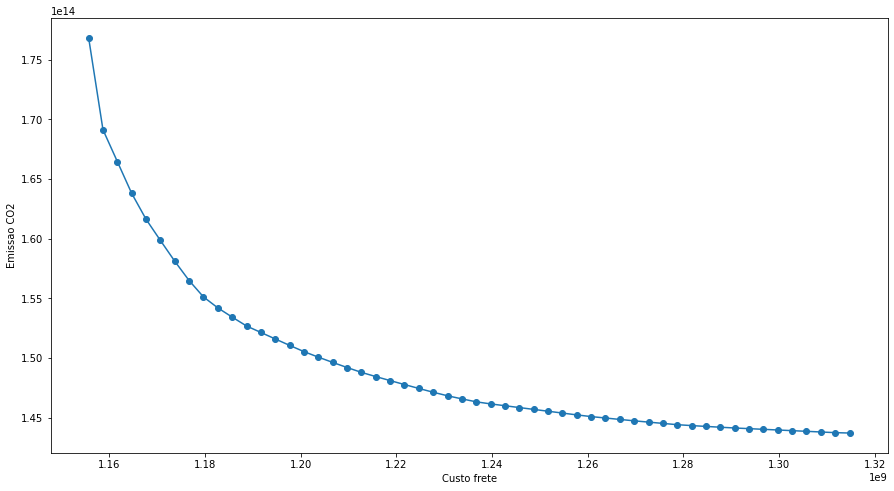

In [125]:

x = np.zeros(len(vals))
y = np.zeros(len(vals))
for i in range(len(vals)):
    x[i], y[i] = vals[i]

fig, ax = plt.subplots(figsize=(15,8))
ax.plot(x, y, marker="o")
ax.set_xlabel('Custo frete')
ax.set_ylabel('Emissao CO2')

In [126]:
vals

[[1155716706.3252413, 176845044596806.0],
 [1158716706.3252413, 169129611401992.28],
 [1161716706.3252413, 166463540220567.94],
 [1164716706.3252413, 163797469039143.62],
 [1167716706.3252413, 161628183969530.25],
 [1170716706.3252413, 159850977541676.62],
 [1173716706.3252416, 158109252026288.12],
 [1176716706.3252418, 156488814287566.94],
 [1179716706.325242, 155117598275586.8],
 [1182716706.325242, 154198656467255.16],
 [1185716706.3252423, 153424517497114.94],
 [1188716706.3252423, 152681459713288.97],
 [1191716706.3252425, 152138086408608.3],
 [1194716706.3252428, 151594713103927.72],
 [1197716706.3252428, 151055842626051.94],
 [1200716706.325243, 150532842521480.47],
 [1203716706.3252432, 150069950212804.22],
 [1206716706.3252432, 149628924464001.38],
 [1209716706.3252435, 149201132625728.53],
 [1212716706.3252437, 148793862876995.38],
 [1215716706.3252437, 148442342573697.7],
 [1218716706.3252437, 148105097172688.72],
 [1221716706.3252437, 147773586562108.25],
 [1224716706.32524